## MNIST data setup

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [6]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(50000, 784) (50000,)
(10000, 784) (10000,)


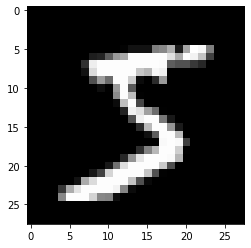

In [7]:
import matplotlib.pyplot as plt 
import numpy as np

plt.imshow(x_train[0].reshape((28,28)), cmap='gray')
plt.show()


In [9]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Neural net from scratch(no torch.nn)

In [29]:
import math

weights = torch.randn(784, 10) / math.sqrt(784) #Xavier initialization
print(weights.requires_grad_())
bias = torch.zeros(10, requires_grad=True)

tensor([[ 0.0007,  0.0203, -0.0539,  ..., -0.0199, -0.0583,  0.0368],
        [ 0.0232,  0.0262,  0.0209,  ...,  0.0236,  0.0390, -0.0446],
        [-0.0279,  0.0152,  0.0427,  ..., -0.0282, -0.0386, -0.0297],
        ...,
        [-0.0051, -0.0219, -0.0217,  ...,  0.0408,  0.0304,  0.0484],
        [ 0.0126, -0.0054, -0.0332,  ...,  0.0014,  0.0175, -0.0321],
        [ 0.0253,  0.0433,  0.0330,  ...,  0.0061, -0.0201, -0.0155]],
       requires_grad=True)


In [30]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1) #activation function 

def model(xb):
    return log_softmax(xb @ weights + bias) # @=matrix mutiplication

In [31]:
bs = 64 #batch size

xb = x_train[0:bs]
preds = model(xb)
print(preds[0], preds.shape)


tensor([-2.8273, -2.0990, -2.1435, -2.7329, -1.9594, -2.4316, -2.2552, -2.6251,
        -2.6026, -1.8593], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [32]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean() #loss function

loss_func = nll

In [33]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3270, grad_fn=<NegBackward0>)


In [34]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [35]:
print(accuracy(preds, yb))

tensor(0.1875)


In [36]:
#trainloop

lr = 0.5
epochs = 2
num_iter = (n-1) // bs + 1

for epochs in range(epochs):
    for i in range(num_iter):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [37]:
#check model loss and accuracy after training 
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0811, grad_fn=<NegBackward0>) tensor(1.)


## Using torch.nn.functional

In [43]:
import torch.nn.functional as F 

loss_func = F.cross_entropy #softmax + loglikelihood 

def model(xb):
    return xb @ weights + bias

In [44]:
#check model loss and accuracy after training 
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0811, grad_fn=<NllLossBackward0>) tensor(1.)


## Refactor using nn.Module

In [45]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [46]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.4971, grad_fn=<NllLossBackward0>)


In [47]:
#training

def fit():
    for epoch in range(epochs):
        for i in range(num_iter):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
 
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [48]:
print(loss_func(model(xb), yb))

tensor(0.1131, grad_fn=<NllLossBackward0>)


In [52]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [53]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2873, grad_fn=<NllLossBackward0>)


In [54]:
fit()
print(loss_func(model(xb), yb))

tensor(0.1132, grad_fn=<NllLossBackward0>)


## Refactor using optim

In [55]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range(num_iter):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2440, grad_fn=<NllLossBackward0>)
tensor(0.1146, grad_fn=<NllLossBackward0>)


## Refactor using Dataset

In [56]:
from torch.utils.data import TensorDataset #will be easier to iterate over and slice.

train_ds = TensorDataset(x_train, y_train)

In [57]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range(num_iter):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.1099, grad_fn=<NllLossBackward0>)


## Refactor using DataLoader

In [58]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [65]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.1519, grad_fn=<NllLossBackward0>)


## Add validation

In [60]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [64]:
model, opt = get_model()
epochs = 2

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

    #valid
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
    
    print(epoch, valid_loss / len(valid_dl))


0 tensor(0.3416)
1 tensor(0.2977)


## Create and fit() and get_data()

In [74]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [75]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [76]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [77]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.36026181643009186
1 0.32607564214468004


## Switch to CNN

In [85]:
class Mnist_CNN(nn.Module):
    def __init__ (self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, 2, 1)
        self.conv3 = nn.Conv2d(16, 10, 3, 2, 1)
    
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [86]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.36360625758171083
1 0.2646517546415329


## nn.Sequential

In [87]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [88]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3867203549861908
1 0.2455592362880707


## Wrapping DataLoader


In [90]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [92]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.43879750061035155
1 0.20990123796761037


In [95]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
print(dev)

def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

cuda


In [96]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [97]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.18624456726312638
1 0.16913957312703132
